In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [224]:
lynx=pd.read_csv("data/lynx.csv", index_col='Year')
lynx.columns=['y']

In [225]:
lynx['y(t-1)']= lynx['y'].shift(1)
lynx['y(t-2)']= lynx['y'].shift(2)

In [226]:
df = lynx.dropna()

In [227]:
df

,y,y(t-1),y(t-2)
Year,,,
1823,585,321.0,269.0
1824,871,585.0,321.0
1825,1475,871.0,585.0
1826,2821,1475.0,871.0
1827,3928,2821.0,1475.0
...,...,...,...
1930,662,485.0,529.0
1931,1000,662.0,485.0
1932,1590,1000.0,662.0


### Посчитаем MSE и подберем оптимальные пар-ры с помощью МНК для AR(2)

In [228]:
def my_mse(cur_df, phi1, phi2, alpha1):
    n = cur_df.shape[0]
    res = 0
    for i in range(n):
        res += (phi1*cur_df['y(t-1)'].values[i]+phi2*cur_df['y(t-2)'].values[i]+alpha1-cur_df['y'].values[i])**2
    return res/n

In [229]:
def get_optimal_params(df):
    return minimize(lambda x: my_mse(df, x[0], x[1], x[2]), (0, 0, 0))

In [230]:
get_optimal_params(df)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 776676.854466659
        x: [ 1.152e+00 -6.062e-01  7.101e+02]
      nit: 6
      jac: [-2.344e-02 -1.562e-02  7.812e-03]
 hess_inv: [[ 4.095e-07 -2.984e-07 -1.646e-04]
            [-2.984e-07  4.078e-07 -1.494e-04]
            [-1.646e-04 -1.494e-04  9.172e-01]]
     nfev: 212
     njev: 50

In [231]:
def my_forecast_values(df, phi1, phi2, alpha1): # для удобства получения массива полученных аппроксимационных значений
    n = df.shape[0]
    y_forc = []
    for i in range(n):
        y_forc.append(phi1*df['y(t-1)'].values[i]+phi2*df['y(t-2)'].values[i]+alpha1)
    return y_forc

In [232]:
forecast=my_forecast_values(df, 1.152e+00, -6.062e-01,  7.101e+02)
df_forecast=pd.DataFrame(forecast)
df_forecast.index=df.index
df_forecast.columns=['y']

Итоговый график

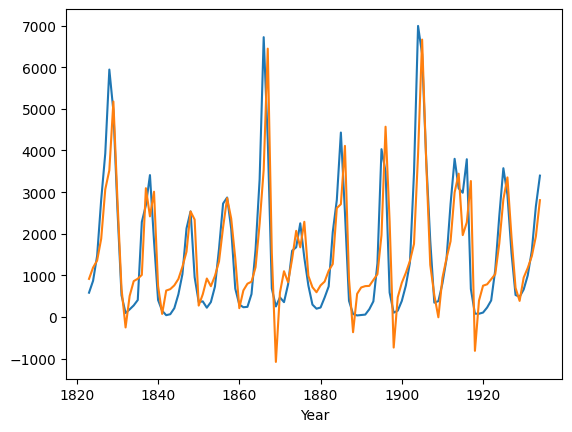

In [233]:
df['y'].plot()
df_forecast['y'].plot()
plt.show()

### Теперь посчитаем MSE и подберем оптимальные пар-ры для MA(2)

In [234]:
def my_real_residuals(y, y_forc): # для удобства получения реальных значений остатков
    n = len(y)
    residuals = []
    for i in range(n):
        residuals.append(y[i]-y_forc[i])
    return residuals

In [235]:
residuals=my_real_residuals(df['y'].values, my_forecast_values(df, 1.152e+00, -6.062e-01,  7.101e+02))

In [236]:
def my_mse_residuals(residuals, theta1, theta2, alpha2):
    n = len(residuals)
    res = 0
    for i in range(2, n):
        res += (theta1*residuals[i-1]+theta2*residuals[i-2]+alpha2-residuals[i])**2
    return res/n

In [237]:
def get_optimal_params_residuals(residuals):
    return minimize(lambda x: my_mse_residuals(residuals, x[0], x[1], x[2]), (0, 0, 0))

In [238]:
get_optimal_params_residuals(residuals)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 757440.600045107
        x: [-2.042e-02 -1.491e-01  4.813e+00]
      nit: 5
      jac: [ 1.562e-02  4.688e-02  3.125e-02]
 hess_inv: [[ 6.474e-07  1.370e-08  2.069e-06]
            [ 1.370e-08  6.507e-07  1.152e-05]
            [ 2.069e-06  1.152e-05  7.617e-01]]
     nfev: 236
     njev: 56

### В итоге можно построить модель ARMA(2, 2), соединив полученные

In [239]:
def my_residual_forecast_values(residuals, theta1, theta2, alpha2):
    n = len(residuals)
    e_forc = []
    for i in range(n):
        e_forc.append(theta1*residuals[i-1]+theta2*residuals[i-2]+alpha2)
    return e_forc

In [240]:
residuals_forc=my_residual_forecast_values(residuals, -2.042e-02, -1.491e-01, 4.813e+00)

In [241]:
def my_forecast_values(df, phi1, phi2, alpha1): # для удобства получения массива полученных аппроксимационных значений
    n = df.shape[0]
    y_forc = []
    for i in range(n):
        y_forc.append(phi1*df['y(t-1)'].values[i]+phi2*df['y(t-2)'].values[i]+alpha1)
    return y_forc

In [242]:
forecast=my_forecast_values(df, 1.152e+00, -6.062e-01,  7.101e+02)

In [243]:
def get_model(forecast, residuals_forc, phi1, phi2, alpha1, theta1, theta2, alpha2):
    n = len(residuals_forc)
    res = []
    for i in range(n):
        res.append(forecast[i]+residuals_forc[i])
    return res

In [244]:
itog=get_model(forecast, residuals_forc, 1.152e+00, -6.062e-01,  7.101e+02, -2.042e-02, -1.491e-01,  4.814e+00)

In [245]:
df_itog=pd.DataFrame(itog)
df_itog.columns=['y']
df_itog.index=df.index

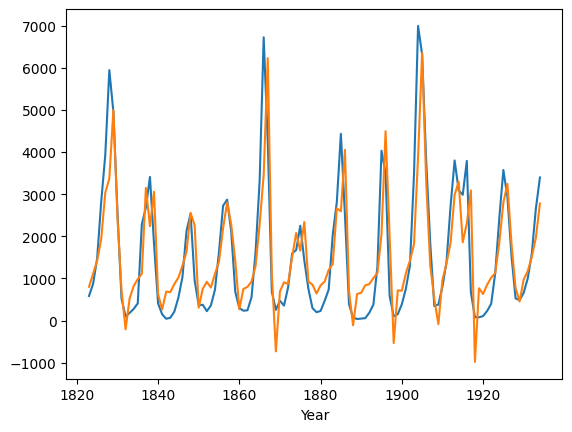

In [246]:
df['y'].plot()
df_itog['y'].plot()
plt.show()

In [247]:
def my_mse_itog(y, y_aprx):
    n = len(y)
    res = 0
    for i in range(n):
        res += (y[i]-y_aprx[i])**2
    return res/n

In [248]:
my_mse_itog(df['y'].values, itog)

758385.045964745

# Видно, что хоть графики AR и ARMA похожи, среднеквадратическая ошибка в ARMA меньше почти на 20 тысяч.